In [1]:
import numpy as np
from sklearn.metrics import log_loss,accuracy_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import pandas as pd 
import xgboost as xgb
import json
from collections import Counter

import gc
from tqdm import tqdm
from itertools import combinations

from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
train_df = pd.read_csv("train.csv",index_col='id')
test_df = pd.read_csv("test.csv")

In [3]:
le = LabelEncoder()

def feature_engineering(df):  
    all_cols = ['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
    categorical_cols = ['Sex']
    
    for c in categorical_cols:
        df.drop(c,axis=1,inplace=True)
        """df[c] = le.fit_transform(df[c]) # Converts categorical column into int format
        df[c] = df[c].astype('category') # Define column type as category """

    #df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2
    #df['Intensity'] = df['Heart_Rate'] / df['Duration']
    
    df.drop(['Age','Height','Weight'],axis=1,inplace=True)
    #df.drop(['Heart_Rate','Body_Temp'],axis=1,inplace=True)


    #df["Body_Temp"] = np.log(df["Body_Temp"])


    gc.collect()
    
    """from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df[['Duration', 'Heart_Rate', 'Body_Temp']]),
                            columns=['Duration', 'Heart_Rate', 'Body_Temp'])"""
    
            
    return df


test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

labels = train_df['Calories']
train_df.drop('Calories',axis=1,inplace=True)

train_df.describe()

,Duration,Heart_Rate,Body_Temp
count,750000.000000,750000.000000,750000.000000
mean,15.421015,95.483995,40.036253
std,8.354095,9.449845,0.779875
min,1.000000,67.000000,37.100000
25%,8.000000,88.000000,39.600000
50%,15.000000,95.000000,40.300000
75%,23.000000,103.000000,40.700000
max,30.000000,128.000000,41.500000


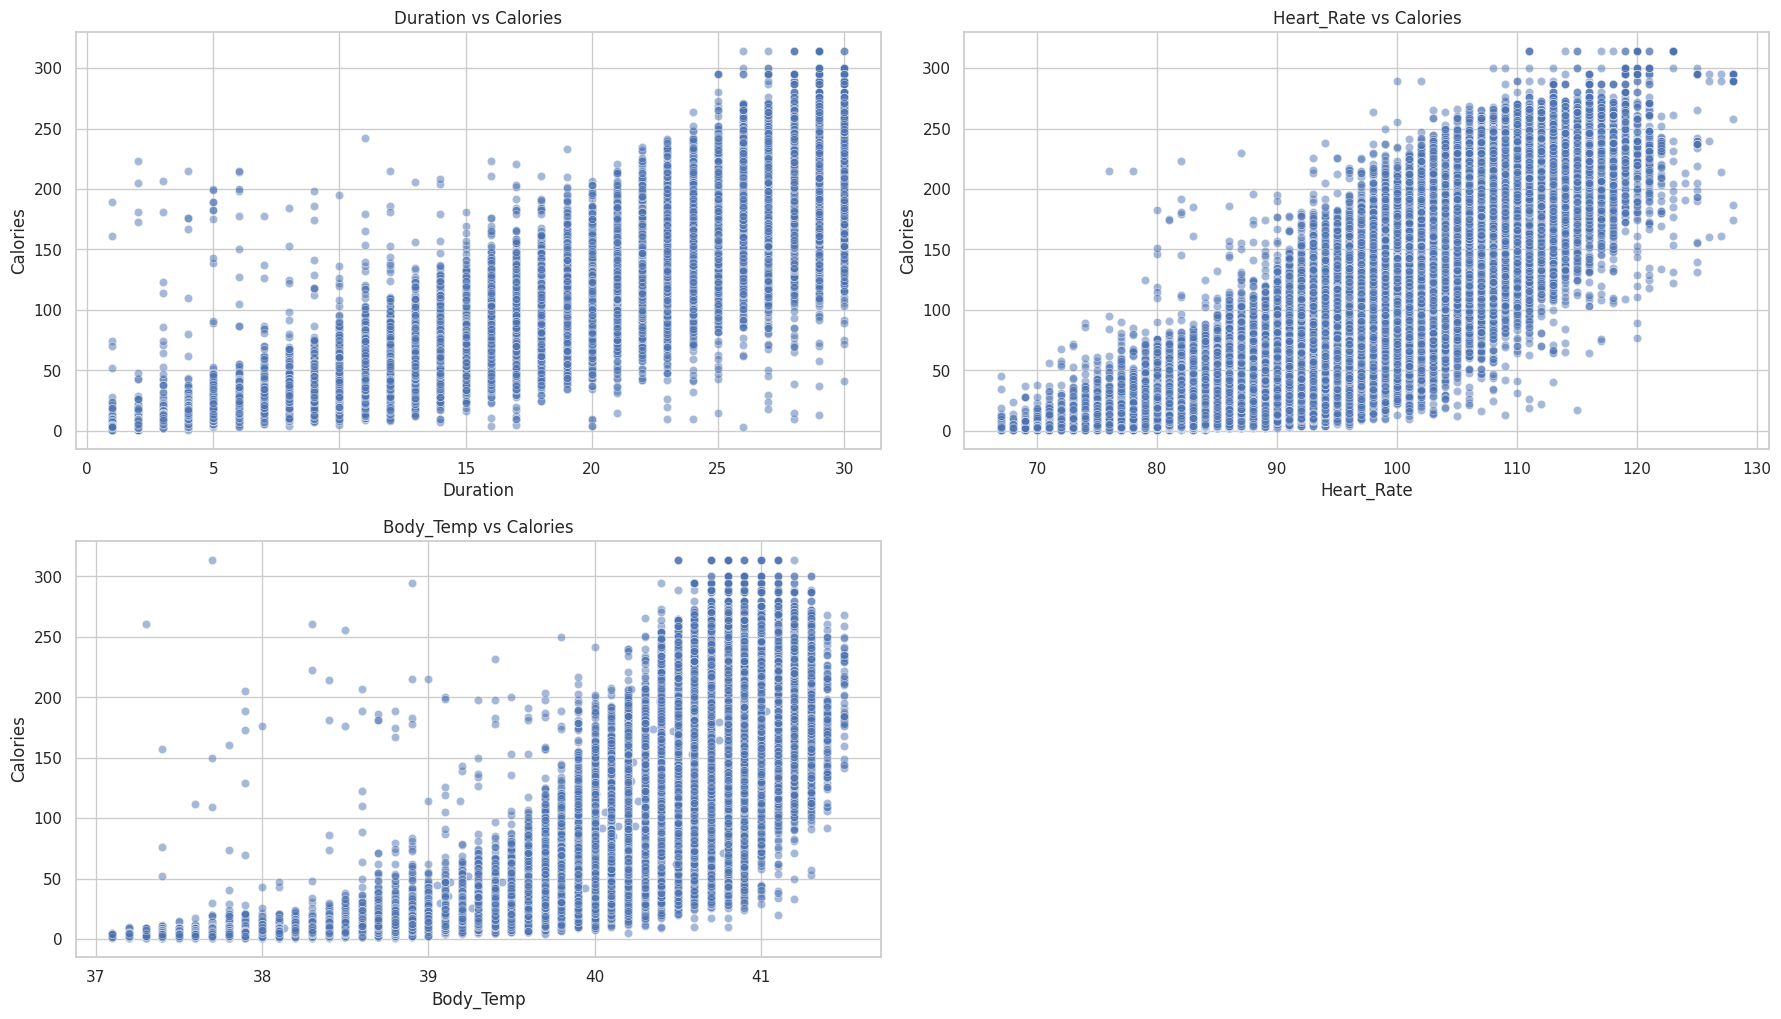

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df_with_label = train_df.copy()
train_df_with_label['Calories'] = labels

sns.set(style="whitegrid")

features = [col for col in train_df.columns]

plt.figure(figsize=(18, 20))

for idx, feature in enumerate(features):
    plt.subplot(4, 2, idx + 1)
    
    if train_df_with_label[feature].dtype.name == 'category':
        sns.boxplot(x=feature, y='Calories', data=train_df_with_label)
    else:
        sns.scatterplot(x=feature, y='Calories', data=train_df_with_label, alpha=0.5)
    
    plt.title(f'{feature} vs Calories')

plt.tight_layout()
plt.show()


In [5]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import ElasticNet

rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)


In [6]:
def regression(df,name):
    X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)


    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0,1.5,1.75,2,3,4,5, 10.0],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0,0.8]
    }

    grid = GridSearchCV(
        estimator=ElasticNet(),
        param_grid=param_grid,
        cv=5,            
        scoring='neg_mean_squared_error', 
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)
    print("Best Score (neg MSE):", grid.best_score_)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    print("Test MSE:", mean_squared_error(y_test, y_pred))

    plt.figure(figsize=(8,5))
    plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel(f"{name}")
    plt.ylabel("Calories")
    plt.title(f"Regression: {name} vs Calories")
    plt.legend()
    plt.grid(True)
    plt.show()

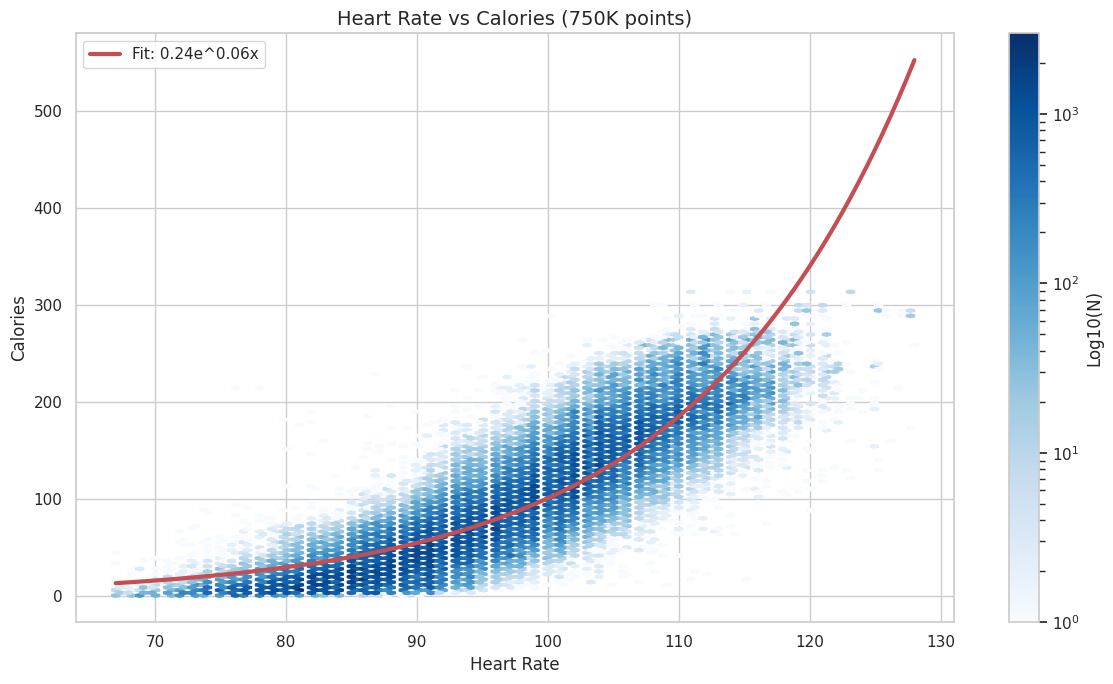

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 20000  # Default is 0
mpl.rcParams['path.simplify_threshold'] = 0.5  # Default 0.111111111111

def exponential_func(x, a, b):
    return a * np.exp(b * x)

def train_exponential_model(feature_series, labels):
    """Returns fitted model parameters and predictions for ALL data points"""
    try:
        params, _ = curve_fit(
            exponential_func,
            feature_series,
            labels,
            p0=[labels.iloc[0], 0.1],  # Initial guess
            maxfev=10000
        )
        a, b = params
        preds = exponential_func(feature_series, a, b)
        return a, b, preds
    except RuntimeError:
        print(f"Failed to fit exponential model for {feature_series.name}")
        return None, None, np.zeros_like(labels)


def plot_model(feature_series, labels, a, b, feature_name):
    plt.figure(figsize=(12, 7))
    
    # Create hexbin plot for density visualization
    hb = plt.hexbin(feature_series, labels, 
                    gridsize=100, 
                    cmap='Blues', 
                    mincnt=1,
                    bins='log')
    
    # Plot exponential curve
    x_values = np.linspace(feature_series.min(), feature_series.max(), 100)
    y_pred = exponential_func(x_values, a, b)
    plt.plot(x_values, y_pred, 'r-', linewidth=3, 
             label=f'Fit: {a:.2f}e^{b:.2f}x')
    
    # Add colorbar and labels
    cb = plt.colorbar(hb)
    cb.set_label('Log10(N)')
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('Calories', fontsize=12)
    plt.title(f'{feature_name} vs Calories (750K points)', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage example for Heart Rate
X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size=0.2, random_state=42)

a_hr, b_hr, preds_hr = train_exponential_model(X_train['Heart_Rate'], y_train)
plot_model(X_train['Heart_Rate'], y_train, a_hr, b_hr, "Heart Rate")

In [10]:
from sklearn.ensemble import GradientBoostingRegressor

submodel_params = {}
submodel_preds = {}

for feature_name in ['Heart_Rate', 'Body_Temp', 'Duration']:
    a, b, preds = train_exponential_model(train_df[feature_name], labels)
    if a is not None:
        print(f"{feature_name} model: Calories = {a:.2f}e^{b:.2f}x")
        submodel_preds[feature_name] = preds
        submodel_params[feature_name] = (a, b)

meta_features = pd.DataFrame({
    'Heart_Rate_Pred': submodel_preds.get('Heart_Rate', 0),
    'Body_Temp_Pred': submodel_preds.get('Body_Temp', 0),
    'Duration_Pred': submodel_preds.get('Duration', 0)
})

meta_features.describe()

Heart_Rate model: Calories = 0.23e^0.06x
Body_Temp model: Calories = 0.00e^1.09x
Duration model: Calories = 21.50e^0.08x


,Heart_Rate_Pred,Body_Temp_Pred,Duration_Pred
count,750000.000000,750000.000000,750000.000000
mean,90.425714,89.221796,89.842242
std,52.641192,54.409501,57.440292
min,13.671402,2.790147,23.270328
25%,48.875930,42.311098,40.475864
50%,74.734712,90.591179,70.402769
75%,121.421741,139.964618,132.533387
max,553.306144,334.104991,230.525468


In [12]:
import optuna
from optuna import Trial
from functools import partial
import xgboost as xgb

def objective(trial: Trial, train_df, labels):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda:0',
        'eval_metric': 'rmsle',
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'subsample': trial.suggest_float('subsample', 0.40, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.95),
        'gamma': trial.suggest_float('gamma', 0.0001, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5),
    }
    dtrain = xgb.DMatrix(meta_features, labels, enable_categorical=True)
    results = xgb.cv(
        params,
        dtrain,
        num_boost_round=10000,
        nfold=3,
        early_stopping_rounds=25,
        metrics={'rmsle'},
        seed=42,
        as_pandas=True,
        verbose_eval=False
    )
    
    return results['test-rmsle-mean'].min()

if True:
    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: objective(trial, train_df, labels),
        n_trials=200,
        n_jobs=1,
        gc_after_trial=True,
        show_progress_bar=True
    )

    

[I 2025-05-14 20:54:37,914] A new study created in memory with name: no-name-4541f901-2a68-48b6-976d-1ba78a7dbb6f


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-05-14 20:57:09,358] Trial 0 finished with value: 0.13625090439398513 and parameters: {'max_depth': 7, 'learning_rate': 0.0013043527715508533, 'subsample': 0.8587785047178014, 'colsample_bytree': 0.8426407819221584, 'gamma': 0.9411790185115884, 'min_child_weight': 8, 'reg_alpha': 2.0944140305796153, 'reg_lambda': 2.346889898558094}. Best is trial 0 with value: 0.13625090439398513.
[I 2025-05-14 20:57:27,343] Trial 1 finished with value: 0.17641977428770753 and parameters: {'max_depth': 4, 'learning_rate': 0.0037475147199683622, 'subsample': 0.7949396737206532, 'colsample_bytree': 0.3370765004602867, 'gamma': 0.05242438452019056, 'min_child_weight': 7, 'reg_alpha': 4.305319295141974, 'reg_lambda': 1.6617167061232865}. Best is trial 0 with value: 0.13625090439398513.
[I 2025-05-14 20:57:38,987] Trial 2 finished with value: 0.1755854026332417 and parameters: {'max_depth': 3, 'learning_rate': 0.00812521314871078, 'subsample': 0.7707156843665488, 'colsample_bytree': 0.192380004900033

KeyboardInterrupt: 

In [ ]:

val_preds = pd.DataFrame()

for feature_name in ['Heart_Rate', 'Body_Temp', 'Duration']:
    a, b = submodel_params.get(feature_name, (0, 0))
    val_preds[f"{feature_name}_Pred"] = exponential_func(X_val[feature_name], a, b)

val_meta_features = pd.concat([val_preds, X_val], axis=1)

final_preds = meta_model.predict(val_meta_features)

print(f"\nMeta Model R²: {r2_score(y_val, final_preds):.4f}")